In [167]:
from sklearn import datasets
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier,BaggingRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

###  1.confusion_matrix实例

In [119]:
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)
#真值为0，预测为0的有2个
#真值为0，预测为1的有0个
#真值为0，预测为2的有0个    

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]], dtype=int64)

### 2.argsort
##### argsort是numpy中的一个函数，用来返回一个数组排好序后各元素对应的原来的位置序号。

In [120]:
c=np.array([3,2,5,1,7,2,9,4])
d=np.argsort(c)
d
#解释：按照从小到大排序后，最小值为1，对应的原来的位置序号为3（从0开始），接下来是2，对应的原来的位置序号为1和5，以此类推。

array([3, 1, 5, 0, 7, 2, 4, 6], dtype=int64)

# 练习1 分类器

In [121]:
#读取数据
biopsy = datasets.load_breast_cancer()  #数据集是一个字典
x=biopsy['data']
y=biopsy['target']
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.3,random_state=14)

### 1）决策树

In [122]:
#决策树
clf = DecisionTreeClassifier(random_state=14)
clf.fit(X_train,Y_train)                                               #拟合决策树
Y_test_pred_onetree = clf.predict(X_test)                              #用测试数据进行预测
accuracy_onetree=np.mean(Y_test_pred_onetree==Y_test)*100              #测试集结果对比
print('The test accuracy is {:.1f}%'.format(accuracy_onetree))

def show_table(y_true,y_pred):
    #混乱矩阵
    matrix=confusion_matrix(y_true,y_pred)
    #构建数据框
    level = np.unique(y_true).tolist()
    Index=['True_'+str(content) for content in level]
    colums=['pred_'+str(content) for content in level]
    return(pd.DataFrame(matrix,index=Index,columns=colums))
show_table(Y_test,Y_test_pred_onetree)


The test accuracy is 90.1%


,pred_0,pred_1
True_0,51,12
True_1,5,103


### 2）Bagging

#### Bagging通过bootstrap多次重复抽样得到多颗决策树，然后根据少数服从多数原则进行投票，通常情况下，结果会优于单颗决策数，但也有例外，如本例

In [123]:
bagging=BaggingClassifier(DecisionTreeClassifier(random_state=14),random_state=14,n_estimators=10) #5颗树，默认10个
bagging.fit(X_train,Y_train)
Y_test_pred_bagging = bagging.predict(X_test)
accuracy_bagging=np.mean(Y_test_pred_bagging == Y_test)*100
print('the test accuracy is {:.1f}%'.format(accuracy_bagging))
show_table(Y_test,Y_test_pred_bagging)

the test accuracy is 94.7%


,pred_0,pred_1
True_0,57,6
True_1,3,105


### 3）随机森林

#### 利用RandomForestClassifier函数设置参数n_estimators=20以此拥有20颗树，并使用feature_importances_找到分类器的重要特征，也是通过bootstrap重抽样生成多颗决策树。区别在于Bagging在生成决策树时利用所有的变量进行训练，而随机森林是随机从自变量中选取一部分进行训练，这样可以提高决策树之间的独立性，提高分类器的泛化能力

In [124]:
rf=RandomForestClassifier(random_state=14,n_estimators=20)
rf.fit(X_train,Y_train)
Y_test_pred_rf=rf.predict(X_test)
accuracy_rf = np.mean(Y_test_pred_rf == Y_test)*100
print('the test accuracy is {:.1f}%'.format(accuracy_rf))
show_table(Y_test,Y_test_pred_rf)

the test accuracy is 94.2%


,pred_0,pred_1
True_0,55,8
True_1,2,106


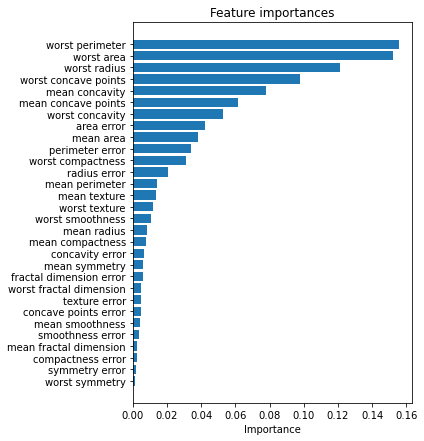

In [125]:
#绘制变量重要程度条形图

features_list = biopsy.feature_names             #提取字典索引名称
feature_importance = rf.feature_importances_     #提取随机森林变量重要性
sorted_idx = np.argsort(feature_importance)      #对变量重要性进行排序
plt.figure(figsize=(5,7))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

###  4）Adaboost

####  adaboost是对bagging进一步改进，它通过不等概率抽样，增大上一次错判样本被抽中的概率，使得分类器对错判的样本也能有一个较好的预测。往往adaboost是对决策树最好的提升。

In [126]:
ada = AdaBoostClassifier(random_state=14,n_estimators=20)
ada.fit(X_train,Y_train)
Y_test_pred_ada = ada.predict(X_test)
accuracy_ada = np.mean(Y_test_pred_ada == Y_test)*100
print('the test accuracy is {:.1f}%'.format(accuracy_ada))
show_table(Y_test,Y_test_pred_ada)

the test accuracy is 94.7%


,pred_0,pred_1
True_0,57,6
True_1,3,105


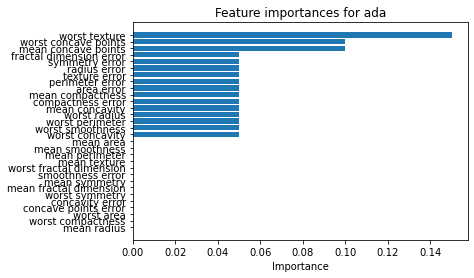

In [127]:
#绘制变量重要程度条形图

features_list = biopsy.feature_names
importance_ada = ada.feature_importances_
sorted_idx_ada = np.argsort(importance_ada)

plt.figure()
plt.barh(range(len(sorted_idx_ada)), importance_ada[sorted_idx_ada])
plt.yticks(range(len(sorted_idx_ada)), features_list[sorted_idx_ada])
plt.xlabel('Importance')
plt.title('Feature importances for ada')
plt.show()

###  5）比较bagging、随机森林、adaboost算法

####  对每种算法进行50次实验，每次实验采用5折交叉验证计算平均准确率
##### K折交叉验证：所谓K折交叉验证，就是将数据集等比例划分成K份，以其中的一份作为测试数据，其他的K-1份数据作为训练数据。然后，这样算是一次实验，而K折交叉验证只有实验K次才算完成完整的一次，也就是说交叉验证实际是把实验重复做了K次，每次实验都是从K个部分选取一份不同的数据部分作为测试数据（保证K个部分的数据都分别做过测试数据），剩下的K-1个当作训练数据，最后把得到的K个实验结果进行平分。

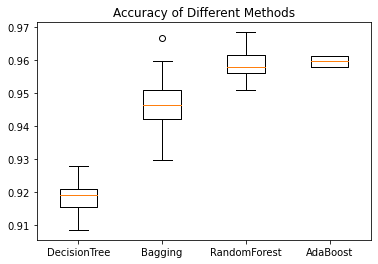

In [130]:
n=50
accuracy_onetree = []
accuracy_bagging = []
accuracy_rf = []
accuracy_ada = []
for i in range(n):
    clf = DecisionTreeClassifier()
    bagging = BaggingClassifier()
    rf =RandomForestClassifier(n_estimators=20)
    ada = AdaBoostClassifier(n_estimators=20)
    accuracy_onetree.append(np.mean(cross_val_score(clf,x,y,scoring='accuracy',cv=5)))
    accuracy_bagging.append(np.mean(cross_val_score(bagging,x,y,scoring='accuracy',cv=5)))
    accuracy_rf.append(np.mean(cross_val_score(rf,x,y,scoring='accuracy',cv=5)))
    accuracy_ada.append(np.mean(cross_val_score(ada,x,y,scoring='accuracy',cv=5)))

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
box = plt.boxplot((accuracy_onetree,accuracy_bagging,accuracy_rf,accuracy_ada),labels=['DecisionTree','Bagging','RandomForest','AdaBoost'])
plt.title('Accuracy of Different Methods')
plt.show()
    

###### fig,ax = plt.subplots()就是
###### fig = plt.figure()
###### ax = fig.add_subplot(1,2,1) 
###### fig, ax = plt.subplots(1,2,1)，中有三个参数，分别表示在一个大的画图空间fig中，参数1和2分别代表子图的行数和列数，也就是我们现在生成了1x2的两个图像。
###### 返回的结果就是，fig画图空间和子图ax的array坐标系列表。
###### fig, ax = plt.subplots(1,2,1)中最后一个参数1代表第1个子图。
###### fig, ax = plt.subplots(1,2,2)中最后一个参数2代表第2个子图

#  练习2 回归树——cpu数据

In [154]:
#读取数据
data = pd.read_csv('cpus.csv',index_col=0)
print(data.tail())
Y=data['perf']
Xnames=data.columns
X=data[Xnames[1:7]]
train_X,test_X,train_y,test_y = train_test_split(X,np.log(Y),test_size=0.3,random_state=5)

                     name  syct  mmin  mmax  cach  chmin  chmax  perf  estperf
205           SPERRY 80/8   124  1000  8000     0      1      8    42       37
206  SPERRY 90/80 MODEL 3    98  1000  8000    32      2      8    46       50
207            STRATUS 32   125  2000  8000     0      2     14    52       41
208             WANG VS10   480   512  8000    32      0      0    67       47
209            WANG VS 90   480  1000  4000     0      0      0    45       25


In [146]:
#描述统计 计算各变量之间的相关性
data.corr()['perf']

syct      -0.307082
mmin       0.794923
mmax       0.862994
cach       0.662613
chmin      0.608903
chmax      0.605219
perf       1.000000
estperf    0.966469
Name: perf, dtype: float64

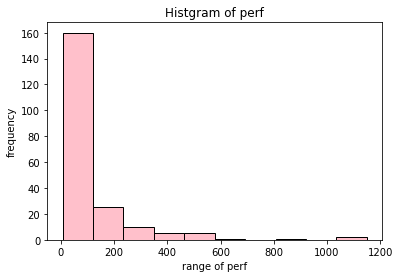

In [147]:
#观察y的分布
plt.hist(Y,color='pink',edgecolor='k')
plt.xlabel('range of perf')
plt.ylabel('frequency')
plt.title('Histgram of perf')
plt.show()

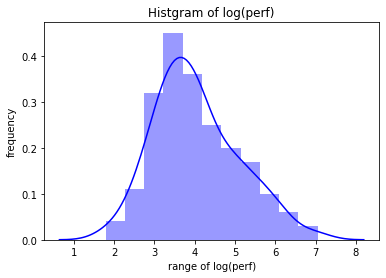

In [153]:
#明显右偏分布，对y进行对数变化
sns.distplot(np.log(Y),color='blue')   #distplot = hist +kdeplot
plt.xlabel('range of log(perf)')
plt.ylabel('frequency')
plt.title('Histgram of log(perf)')
plt.show()

###  1）回归树

#####  利用10折交叉验证比较不同深度树的拟合效果，评价指标用MSE，不同深度意味着不同拟合程度

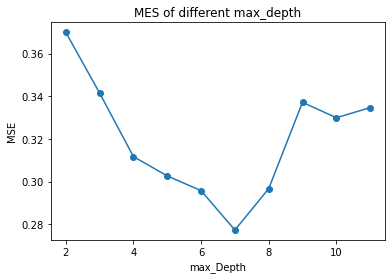

In [161]:
mse=[]
for depth in np.arange(2,12):
    reg=DecisionTreeRegressor(max_depth=depth)
    mse.append(np.mean(abs(cross_val_score(reg,X,np.log(Y),scoring='neg_mean_squared_error',cv=10))))
plt.plot(np.arange(2,12),mse,'o-')
plt.title('MES of different max_depth')
plt.xlabel('max_Depth')
plt.ylabel('MSE')
plt.show()

MSE为：0.233502
R²为：0.810344


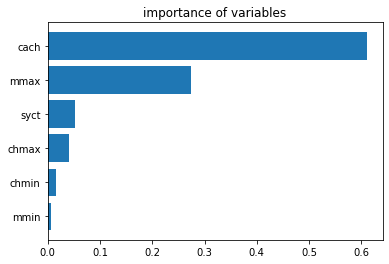

In [166]:
#上图显示，深度为7时，达到最小mse,绘制变量重要程度条形图
reg = DecisionTreeRegressor(max_depth=7).fit(train_X,train_y)
reg_pred = reg.predict(test_X)
MSE = np.mean((test_y-reg_pred)**2)
SCORE =reg.score(test_X,test_y)    #R²
print('MSE为：{:f}'.format(MSE))
print('R²为：{:f}'.format(SCORE))
importance_reg = reg.feature_importances_
feather_names = X.columns
sorted_reg = np.argsort(importance_reg)

plt.figure()
plt.barh(range(len(feather_names)),importance_reg[sorted_reg])
plt.yticks(range(len(sorted_reg)), feather_names[sorted_reg])
plt.title('importance of variables')
plt.show()


###  2)组合算法：bagging、随机森林、adaboost

####  bagging

In [174]:
bagging=BaggingRegressor(random_state=5)
bagging.fit(train_X,train_y)
bagging_pred=bagging.predict(test_X)

mse_bagging=(np.mean(abs(cross_val_score(bagging,X,np.log(Y),scoring='neg_mean_squared_error',cv=10))))
score_bagging=bagging.score(test_X,test_y)
print('MSE为：{:f}'.format(mse_bagging))
print('R²为：{:f}'.format(score_bagging))

MSE为：0.230933
R²为：0.850804
